Trabalho com TensorFlow

In [1]:
import tensorflow as tf

In [2]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [3]:
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

In [4]:
tf.__version__   # versão 2.3 do TensorFlow, que é a mais atualizada

'2.3.0'

In [6]:
# importa a base de dados de flores licenciada da creative-commons
import pathlib
data_dir = tf.keras.utils.get_file(origin='http://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
                                   fname='flower_photos', untar=True)
data_dir = pathlib.Path(data_dir)

228818944/228813984 [==============================] - 1s 0us/step


In [7]:
# a base de dados possui 5 subdiretórios: daisy, dandelion, roses, sunflowers, tulips
image_count = len(list(data_dir.glob('*/*.jpg')))
image_count    # total de 3670 imagens

3670

In [12]:
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != 'LICENSE.txt'])  # descarta o arquivo LICENSE.txt e transforma em array
CLASS_NAMES

array(['tulips', 'sunflowers', 'daisy', 'dandelion', 'roses'],
      dtype='<U10')

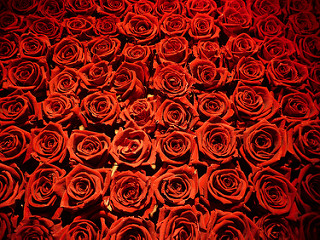

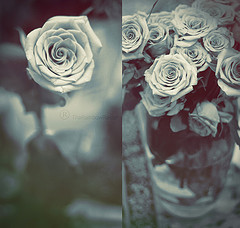

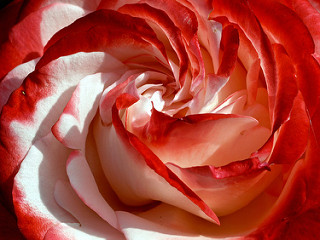

In [14]:
# faz uma listagem das rosas
roses = list(data_dir.glob('roses/*'))
for image_path in roses[:3]:
  display.display(Image.open(str(image_path)))

Utiliza o keras.preprocessing - uma maneira mais simples de carregar imagens

In [15]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [16]:
# define alguns parâmetros para a carga
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

In [17]:
train_data_gen = image_generator.flow_from_directory(directory=str(data_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes=list(CLASS_NAMES))

Found 3670 images belonging to 5 classes.


In [18]:
# inspeciona o lote
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off') 

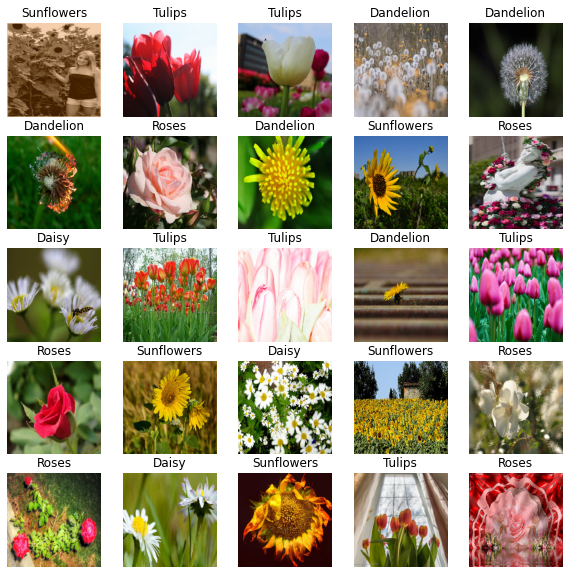

In [19]:
image_batch, label_batch = next(train_data_gen)
show_batch(image_batch, label_batch)

Agora carregando com tf.data

obs.: o keras.preprocessing é lento

In [20]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))

In [21]:
for f in list_ds.take(5):
  print(f.numpy())

b'/root/.keras/datasets/flower_photos/dandelion/146023167_f905574d97_m.jpg'
b'/root/.keras/datasets/flower_photos/dandelion/10200780773_c6051a7d71_n.jpg'
b'/root/.keras/datasets/flower_photos/daisy/7133935763_82b17c8e1b_n.jpg'
b'/root/.keras/datasets/flower_photos/roses/4754734410_94d98463a5.jpg'
b'/root/.keras/datasets/flower_photos/tulips/14266093711_66d18a1e44_n.jpg'


In [22]:
# cria uma função pure-tensorflow que converte um caminho de arquivo em um par (img, label)
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # the second to last is the class-directory
  return parts[-2] == CLASS_NAMES

In [23]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size
  return tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])

In [24]:
def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label


In [25]:
# usa Dataset.map para criar um conjunto de dados de imagem, pares de rótulos #

# set ´num_parallel_calls´ so multiple images are loaded/processed in parallel.
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE) 

In [26]:
for image, label in labeled_ds.take(1):
  print('Image shape: ', image.numpy().shape)
  print('Label: ', label.numpy())

Image shape:  (224, 224, 3)
Label:  [False False False False  True]


Métodos básico para treinamento, usando a API tf.data

In [27]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
  # This is a small dataset, only load it once, and keep in in memory.
  # use ´.cache(filename´) to cache preprocessing work for datasets that don't 
  # fit in memory.
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  ds = ds.shuffle(buffer_size=shuffle_buffer_size)

  # repeat forever
  ds = ds.repeat()

  ds = ds.batch(BATCH_SIZE)

  # ´prefetch´ lets the dataset fetch batches in the background while the model 
  # is treining.
  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds

In [28]:
train_ds = prepare_for_training(labeled_ds)

image_batch, label_batch = next(iter(train_ds))

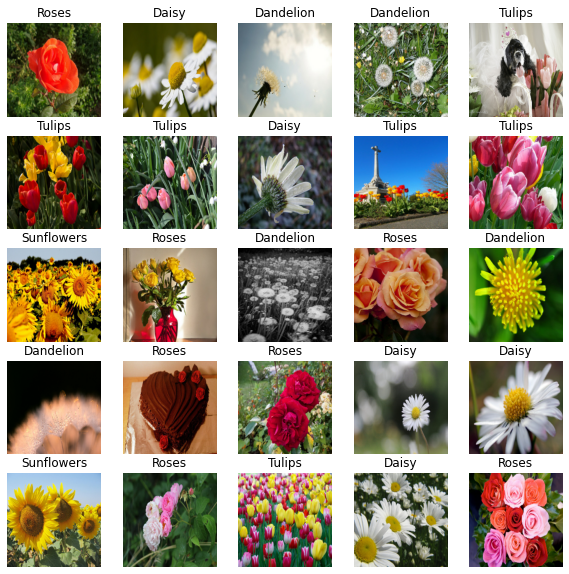

In [29]:
show_batch(image_batch.numpy(), label_batch.numpy())

Investigando a performance

In [30]:
import time
default_timeit_steps = 1000

def timeit(ds, steps=default_timeit_steps):
  start = time.time()
  it = iter(ds)
  for i in range(steps):
    batch = next(it)
    if 1%10 == 0:
      print('.', end='')
  print()
  end = time.time()

  duration = end-start
  print('{} batches: {} s'.format(steps, duration))
  print('{:0.5f} Images/s'.format(BATCH_SIZE*steps/duration))

In [31]:
# agora vamos comparar a velocidade dos dois geradores de dados

# keras.preprocessing
timeit(train_data_gen)


1000 batches: 98.21073365211487 s
325.82997 Images/s


In [32]:
# tf.data
timeit(train_ds)


1000 batches: 14.769319534301758 s
2166.65364 Images/s


In [33]:
# agora tirando o cache
uncached_ds = prepare_for_training(labeled_ds, cache=False)
timeit(uncached_ds)


1000 batches: 69.45791244506836 s
460.71065 Images/s


Deu uma diferença gigante utilizando o tf.data com cache.
Caso o dataset não couber na memória, pode ser usado um arquivo de cache, como abaixo

In [34]:
# utilizando cache em disco
filecache_ds = prepare_for_training(labeled_ds, cache='./flowers.tfcache')
timeit(filecache_ds)


1000 batches: 31.93038511276245 s
1002.18021 Images/s


Conclusão: o cache em memória é o mais rápido, como era de se esperar, mas o cache em disco ficou mais rápido que o método keras.preprocessing